# LLM Agents

*The true sign of intelligence is not knowledge but imagination* - Albert Einstein

We introduce the capabilities of LLM agents using chatbots with memory, retrieval-augmented generation (RAG), and multi-agent collaboration. Employing Microsoft’s Phi-4-mini model, a ChromaDB vector store and sentence embedding models via Ollama, we demonstrate how LLMs can be enhanced to improve factual accuracy and support long-context reasoning. The final application centers around measuring the value of corporate philanthropy, illustrating how agents can ground their reasoning in retrieved knowledge and engage in multi-role dialogue to develop actionable plans.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import torch
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig, logging
import io
import soundfile
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from pprint import pprint
import warnings
import textwrap
def wrap(text):
    """Helper to wrap text for pretty printing"""
    return "\n".join([textwrap.fill(s, width=80) for s in text.split('\n')])
torch.random.manual_seed(0)
logging.set_verbosity_error() 
# display gpu and memory
gpu_stats = torch.cuda.get_device_properties(0)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")


GPU = NVIDIA GeForce RTX 3080 Laptop GPU. Max memory = 15.739 GB.


## Microsoft Phi-4 model

The Microsoft Phi-4 family is designed for compactness and strong reasoning across modalities. 
Released in February 2024, Phi-4-multimodal is a 5.6B parameter model which processes audio, vision, and language simultaneously within the same representation space. Its capabilities include:

- Instruction following: Instruct-tuned for multi-turn conversation, summarization, Q&A
- Math and code reasoning: Fine-tuned on mathematical and coding data
- Multilingual: Supports multiple languages with cross-lingual reasoning
- Vision: integrates a visual encoder that converts image inputs into embeddings, supporting tasks such as
  - OCR (Optical Character Recognition)
  - chart and table understanding
  - image-based reasoning (e.g., figures, diagrams)
- Audio Capabilities: a specialized audio encoder for speech inputs, supporting:
  - Automatic Speech Recognition (ASR)
  - Multilingual speech translation

https://azure.microsoft.com/en-us/blog/empowering-innovation-the-next-generation-of-the-phi-family/


In [2]:
# load and configures Phi-4-mini-instruct using HuggingFace
model_path = "microsoft/Phi-4-mini-instruct"
model_path = "microsoft/Phi-4-multimodal-instruct"

with warnings.catch_warnings():  # ignore small sample warnings
    warnings.simplefilter("ignore")  
    processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

    print(processor.tokenizer)

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        trust_remote_code=True,
        torch_dtype='auto',
        _attn_implementation='flash_attention_2',
        #    _attn_implementation='eager',     # 'flash_attention_2',
    ).cuda()

GPT2TokenizerFast(name_or_path='microsoft/Phi-4-multimodal-instruct', vocab_size=200019, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	199999: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	200010: AddedToken("<|endoftext10|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	200011: AddedToken("<|endoftext11|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	200018: AddedToken("<|endofprompt|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	200019: AddedToken("<|assistant|>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=True),
	200020: AddedToken("<|end|>", rstrip=T

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Memory usage

In [3]:
def cuda_memory():
    """Show GPU memory free"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        total_memory = torch.cuda.get_device_properties(device).total_memory
        reserved_memory = torch.cuda.memory_reserved(device)
        allocated_memory = torch.cuda.memory_allocated(device)
        free_memory = total_memory - reserved_memory
        print(f"Total memory: {total_memory / (1024**3):.2f} GB")
        print(f"Reserved memory: {reserved_memory / (1024**3):.2f} GB")
        print(f"Allocated memory: {allocated_memory / (1024**3):.2f} GB")
        print(f"Free memory: {free_memory / (1024**3):.2f} GB")

cuda_memory()


Total memory: 15.74 GB
Reserved memory: 10.45 GB
Allocated memory: 10.42 GB
Free memory: 5.29 GB


Generate model response

In [4]:
generation_args = {
    "max_new_tokens": 512,
    #"return_full_text": False,
    "temperature": 0.6,   # nonzero so that chat responses can vary slightly
    "do_sample": True,    # False,
}
generation_config = GenerationConfig.from_pretrained(model_path, 
                                                     'generation_config.json')

Helpers to format content to prompt for response

In [5]:
def create_content(query, image=None, audio=None):
    """Formats a message content string"""
    image_prompt = '' if image is None else '<|image_1|>'
    audio_prompt = '' if audio is None else '<|audio_1|>'
    prompt = f'{image_prompt}{audio_prompt}{query}'
    return prompt

def create_prompt(query, image=None, audio=None):
    """Generate a single prompt for inference response"""
    user_prompt = '<|user|>'
    assistant_prompt = '<|assistant|>'
    prompt_suffix = '<|end|>'
    content = create_content(query, image=image, audio=audio)
    prompt = f'{user_prompt}{content}{prompt_suffix}{assistant_prompt}'
    return prompt

def pipe(query, image=None, audio=None, verbose=False, **kwargs):
    """Pipeline to format and send query, and generate and decode response"""
    if isinstance(query, list):  # query input is given as a list of messages
        prompt = processor.tokenizer.apply_chat_template(query,
                                                         tokenize=False,
                                                         add_generation_prompt=True)
        # remove last <|endoftext|> if it is there, which is used for training, not inference.
        # For training, make sure to add <|endoftext|> in the end.
        if prompt.endswith('<|endoftext|>'):
            prompt = prompt.rstrip('<|endoftext|>')
    elif isinstance(query, str): # query input is given as a string
        prompt = create_prompt(query, image=image, audio=audio)    
    else:
        raise Exception('Invalid prompt format, must be str or list of messages')
    if verbose:
        print(prompt)
    inputs = processor(prompt, images=image, audios=audio, return_tensors='pt').to('cuda:0')

    with warnings.catch_warnings():  # ignore small sample warnings                                       
        warnings.simplefilter("ignore")

        generate_ids = model.generate(
            **inputs,
            generation_config=generation_config,
            # https://huggingface.co/microsoft/Phi-4-multimodal-instruct/discussions/46        
            num_logits_to_keep=1,
            **kwargs,
    )
    generate_ids = generate_ids[:, inputs['input_ids'].shape[1] :]
    response = processor.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    return response

## Chatbot

A chatbot simulates ongoing dialogue between a user and an LLM. By appending previous user inputs and model responses into the prompt, the chatbot maintains conversational memory. This enables it to handle follow-up questions, build on earlier answers, and maintain topic continuity over multiple turns.
During a chat session, the prompt is iteratively expanded to include each previous exchange. This accumulated memory allows the model to generate responses that take prior context into account. 

Simulate user queries

In [6]:
# Simulate a sequence of user queries to be processed
sequence_user_queries = [
    "What are the challenges to measuring the value of corporate philanthropy?",
    "Please suggest some solutions.",
    "Thank you, please concisely summarize into an action plan."
]

### Memory

During a chat session, the prompt is iteratively expanded to include each previous exchange. This accumulated memory allows the model to generate responses that take prior context into account. The final response is displayed, along with the complete prompt history used in that turn—demonstrating how memory accumulation influences generation.


In [18]:
# Prompt grows over time with user and assistant turns.
memory = []   # memory of past AI-assistant turns
for turn in range(len(sequence_user_queries)):

    # Add initial user query
    query = sequence_user_queries[0]
    messages = [{"role": "user", "content": query}]

    # 3. Loop through past turns of AI response and user prompts
    for response, query in zip(memory, sequence_user_queries[1:len(memory)+1]):

        # Add AI assistant's response
        messages.append({"role": "assistant", "content": response})

        # Add user's next query
        messages.append({"role": "user", "content": query})

    # 4. Generate response and save to memory
    output = pipe(messages, **generation_args)
    memory.append(output)
    print(f'----------- {turn=} -----------')
    print('QUERY:', query)
    print('RESPONSE:')
    print(wrap(memory[-1]))
    print()

 33%|███▎      | 1/3 [00:21<00:42, 21.09s/it]

----------- turn=0 -----------
QUERY: What are the challenges to measuring the value of corporate philanthropy?
RESPONSE:
Measuring the value of corporate philanthropy presents several challenges,
including:

1. Lack of standardized metrics: There is no universally accepted way to measure
the impact of corporate philanthropy. Different organizations may use different
metrics, making it difficult to compare and assess the value of their
philanthropic efforts.

2. Difficulty in quantifying social impact: Corporate philanthropy often aims to
address complex social issues, making it challenging to quantify the impact.
Social impact can be long-term and may not be immediately visible, requiring a
long-term perspective to assess the value of corporate philanthropy.

3. Lack of transparency: Corporate philanthropy can be seen as a way for
companies to boost their public image, rather than a genuine effort to make a
positive impact. This lack of transparency can make it difficult to assess the

 67%|██████▋   | 2/3 [00:43<00:21, 21.72s/it]

----------- turn=1 -----------
QUERY: Please suggest some solutions.
RESPONSE:
To address the challenges of measuring the value of corporate philanthropy, the
following solutions can be considered:

1. Develop standardized metrics: Establishing universally accepted metrics and
guidelines for measuring the impact of corporate philanthropy can help
organizations compare and assess their efforts more effectively. These metrics
could include both quantitative and qualitative measures, such as the number of
people served, the amount of money donated, and the long-term impact on
communities.

2. Focus on social impact: Companies should prioritize measuring the social
impact of their philanthropic efforts, rather than just financial outcomes. This
can be done by setting clear goals and objectives, tracking progress over time,
and using both quantitative and qualitative data to assess the impact on the
communities and individuals they serve.

3. Increase transparency: Companies should be trans

100%|██████████| 3/3 [00:59<00:00, 19.80s/it]

----------- turn=2 -----------
QUERY: Thank you, please concisely summarize into an action plan.
RESPONSE:
Action Plan for Measuring the Value of Corporate Philanthropy:

1. Develop standardized metrics:
   - Establish universal guidelines and metrics for measuring the impact of
corporate philanthropy.
   - Include both quantitative and qualitative measures, such as the number of
people served, amount of money donated, and long-term community impact.

2. Focus on social impact:
   - Set clear goals and objectives for philanthropic efforts.
   - Track progress over time using both quantitative and qualitative data.
   - Assess the impact on communities and individuals served.

3. Increase transparency:
   - Be transparent about philanthropic efforts, including selection processes,
outcomes, and reasons behind giving.
   - Share information with stakeholders to build trust and demonstrate genuine
impact.

4. Improve attribution methods:
   - Use data analysis, case studies, and stakehold

Show the final response from the last turn of the Chatbot

In [19]:
print('FINAL ANSWER:')
print(wrap(output))

FINAL ANSWER:
Action Plan for Measuring the Value of Corporate Philanthropy:

1. Develop standardized metrics:
   - Establish universal guidelines and metrics for measuring the impact of
corporate philanthropy.
   - Include both quantitative and qualitative measures, such as the number of
people served, amount of money donated, and long-term community impact.

2. Focus on social impact:
   - Set clear goals and objectives for philanthropic efforts.
   - Track progress over time using both quantitative and qualitative data.
   - Assess the impact on communities and individuals served.

3. Increase transparency:
   - Be transparent about philanthropic efforts, including selection processes,
outcomes, and reasons behind giving.
   - Share information with stakeholders to build trust and demonstrate genuine
impact.

4. Improve attribution methods:
   - Use data analysis, case studies, and stakeholder feedback to better
attribute outcomes to corporate philanthropy.
   - Identify direct and 

## Retrieval-augmented generation

One major challenge in standard LLMs is **hallucination**, where the model produces text that sounds believable but is actually false or unsupported by facts. Because LLMs are trained to model word sequences rather than factual accuracy, they can sometimes generate convincing yet misleading statements—especially when no clear answer exists in their training data. For example, Hicks et al. (2024) argue that LLMs are "bullshit machines" that prioritize fluent language over truth. Similarly, Mahowald et al. (2023) caution against assuming that skill with language equates to actual reasoning or understanding.

RAG addresses this issue by anchoring the model’s responses in retrieved documents, making the output more factually reliable. In a common implementation known as prompt-based in-context retrieval, the system first retrieves information from an external knowledge base, and then it generates a response based on that retrieved content. The LLM is prompted with the relevant document and instructed to answer solely based on that information, similar to reading a reference article before answering a question, allowing for better factual accuracy and handling of long-context tasks. RAG is increasingly used in several practical domains:

- Search-Augmented LLMs improve accuracy in fact-checking and open-domain Q&A tasks.
- Enterprise Applications enable better handling of legal, financial, and medical documents.
- Personalized AI Assistants can use retrieval to support domain-specific queries using private or proprietary knowledge bases (e.g., for customer service).

For evaluating **closed-domain question-answering (QA)** LLMs, benchmarks such as SQuAD (Stanford Question Answering Dataset) HotpotQA are used, focusing on a system's ability to answer questions within specific documents, including tasks like complex document comprehension and multi-hop reasoning. This task differs from **open-domain QA**, where LLMs are expected to draw knowledge from a vast, unrestricted knowledge base.

More advanced data structures have also been employed for RAG, such as RAPTOR by Sarthi et al (2024), which organizes data and recursive summaries in a tree structure, integrating information across lengthy documents for better performance on complex, multi-step reasoning tasks

The LangChain framework offers flexible tools for loading and preprocessing input documents of many formats. A textbook is read and divided into chunks of roughly 1,000 characters with some overlap. These chunks provide manageable input sizes for retrieval while maintaining continuity. The text itself outlines how companies can measure philanthropic value through social, business, and investor-oriented metrics, and forms the knowledge base for grounding agent responses.

In [9]:
# LangChain to loads and split documents into chunks for retrieval
from langchain_community.document_loaders import TextLoader, UnstructuredMarkdownLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [10]:
# Loads markdown file (MVCP.md) and split into overlapping chunks
loader = TextLoader('assets/MVCP.md')
document = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunked_documents = text_splitter.split_documents(document)

In [11]:
print('Number of chunks:', len(chunked_documents))
print(wrap(str(chunked_documents[:2])))

Number of chunks: 196
[Document(metadata={'source': 'assets/MVCP.md'}, page_content='MEASURING THE
VALUE OF CORPORATE PHILANTHROPY: SOCIAL IMPACT, BUSINESS BENEFITS, AND INVESTOR
RETURNS\nby\nTerence Lim, Ph.D.\nReport Author and Manager, Standards and
Measurement,\nCommittee Encouraging Corporate Philanthropy\n(through the
2008–2009 Goldman Sachs Public Service Program)\n\nHow to measure the value and
results of corporate philanthropy remains\none of corporate giving
professionals’ greatest challenges. Social and\nbusiness benefits are often
long-term or intangible, which make\nsystematic measurement complex. And yet:
Corporate philanthropy faces\nincreasing pressures to show it is as
strategic,cost-effective, and value-enhancing\nas possible. The industry faces a
critical need to assess current practices and\nmeasurement trends, clarify the
demands practitioners face for impact evidence,\nand identify the most promising
steps forward in order to make progress on these\nchallenges.'),

### ChromaDB vector database

ChromaDB is an open-source vector store used to store and retrieve text embeddings. It enables fast and efficient semantic search, allowing the system to find the most relevant document chunks based on a given query. 


For compatibility, ChromaDB requires SQLite version 3.35 or higher. If the system uses an older version, apply this workaround patch: Install pysqlite3-binary, then enter the following three lines in sqlite_version.py to swap the packages.


In [12]:
# kludge to hack ChromaDB to use lower version of SQLite
with open('sqlite_version.py', 'w') as f:
    f.write('''__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
    '''.strip())
import sqlite_version

In [13]:
# ChromaDB vector store to store and retrieve document embeddings.
import chromadb
client = chromadb.Client()
try:
    client.delete_collection(name="docs") 
except:
    pass
#collection = client.get_or_create_collection(name="docs")
collection = client.create_collection(name="docs")



The sentence embeddings for both documents and queries are generated using the `mxbai-embed-large` model served via **Ollama**. This embedding model, which reached state-of-the-art performance in April 2024, was trained on over 700 million high-quality sentence pairs and fine-tuned on 30 million triplets. These embeddings are stored in ChromaDB to support rapid document retrieval.


In [14]:
# Ollama for generating sentence embeddings using mxbai-embed-large model
# !ollama pull mxbai-embed-large
import ollama

# store chunk embeddings in a vector database
for i, d in enumerate(chunked_documents):
    response = ollama.embeddings(model="mxbai-embed-large", prompt=d.page_content)
    embedding = response["embedding"]
    collection.add(
        ids=[str(i)],
        embeddings=[embedding],
        documents=[d.page_content],
    )



### Retrieval
    
The retrieval pipeline consists of four main steps:

- A user query is written in natural language.
- The query is embedded using the same model as the document chunks.
- The top 5 most semantically similar chunks are retrieved from the ChromaDB vector store.
- A new prompt is constructed by combining the user’s question with the retrieved content for generation.


In [15]:

# A sample question prompt
query = "What are the challenges to measuring the value of corporate philanthropy?"

Embed the prompt query


In [16]:
# generate an embedding for the query
response = ollama.embeddings(
  prompt=query,
  model="mxbai-embed-large"
)
len(response['embedding'])   # vector length

1024

Retrieve the 5 most similar document chunks from the vector database

In [17]:
# ses ChromaDB to find top 5 most similar chunks
results = collection.query(
  query_embeddings=[response["embedding"]],
    n_results=5,
)
for data in results['documents'][0]:
  print(textwrap.fill(data))

MEASURING THE VALUE OF CORPORATE PHILANTHROPY: SOCIAL IMPACT, BUSINESS
BENEFITS, AND INVESTOR RETURNS by Terence Lim, Ph.D. Report Author and
Manager, Standards and Measurement, Committee Encouraging Corporate
Philanthropy (through the 2008–2009 Goldman Sachs Public Service
Program)  How to measure the value and results of corporate
philanthropy remains one of corporate giving professionals’ greatest
challenges. Social and business benefits are often long-term or
intangible, which make systematic measurement complex. And yet:
Corporate philanthropy faces increasing pressures to show it is as
strategic,cost-effective, and value-enhancing as possible. The
industry faces a critical need to assess current practices and
measurement trends, clarify the demands practitioners face for impact
evidence, and identify the most promising steps forward in order to
make progress on these challenges.
detailed insights into the related measurement process which can help
demonstrate understanding of wha

### Generation

Construct the prompt combining the query and supporting context retrieved.
Then send to the LLM, which generates a grounded response.


In [19]:
# assembles relevant chunks into a prompt alongside the original question
prompt = f"""
Only use relevant information in the following text delimited by triple quotes:

'''{data}.''' 

Respond to this prompt: {query}."""

In [20]:
# send a conversation-style chat-template prompt incorporating the retrieved text
messages = [
    {"role": "user", "content": prompt},    
]
output = pipe(messages, **generation_args)
print('QUERY:', query)
print('RESPONSE:')
print(wrap(output))

QUERY: What are the challenges to measuring the value of corporate philanthropy?
RESPONSE:
The challenges to measuring the value of corporate philanthropy include:

1. Social and business benefits are often long-term or intangible, making
systematic measurement complex.
2. Corporate philanthropy faces increasing pressures to show it is as strategic,
cost-effective, and value-enhancing as possible.
3. The industry faces a critical need to assess current practices and
measurement trends.
4. There is a need to clarify the demands practitioners face for impact
evidence.
5. Identifying the most promising steps forward to make progress on these
challenges.
6. Demonstrating understanding of what drives long-term business success and
quality of management.
7. Measuring the financial value of enhancing intangibles such as a company's
reputational and human capital can be complex and may not be directly
convertible into tangible bottom-line profits in the near term.
8. The measurement of social 

## Multi-agents

In multi-agent workflows, multiple LLM agents play different roles and collaborate to accomplish a shared objective. In this demonstration, three role-playing agents work together to simulate human-like decision-making processes:

- A Chief Executive Officer (CEO) asks strategic questions about measuring philanthropic value.
- A Chief Giving Officer (CGO) synthesizes responses into an evolving plan.
- An AI Assistant (nicknamed CorGi) uses RAG to answer the CEO’s questions using only retrieved text.

The agents interact with each other over several turns, collaboratively building and refining a plan grounded in the corporate philanthropy document.

### Tool calling

Traditional LLMs are limited in that they cannot retrieve live data or execute real-world functions unless explicitly programmed. Without tools, they may also make computational errors or respond inconsistently to ambiguous prompts. Recent advances focus on enabling tool use, where LLMs can:
- Make function calls.
- Use APIs to gather real-time data.
- Perform calculations or database lookups.

The main approaches include:
- Allow the model to generate function calls instead of plain text.
- Zero-Shot Tool Use: Models learn to use tools on-the-fly via structured prompts.
- Fine-Tuned Tool Use: Models are trained to recognize and call specific functions during generation.



__AI Assistant agent:__

The AI Research Assistant agent responds to queries by leveraging RAG. Its prompt instructs it to only use retrieved documents to answer and to reply "I don’t know" if the information isn’t found in the text. This strict constraint helps minimize hallucination and ensures that all responses are grounded in the knowledge base.

In [22]:
# AI assistant agent answers using only retrieved text chunks
def rag_agent(query, n_results=5):
    """Role of a RAG-based question-answering agent"""
    response = ollama.embeddings(prompt=query, model="mxbai-embed-large")

    results = collection.query(query_embeddings=[response["embedding"]],
                               n_results=n_results)
    text = "\n".join(results['documents'][0])

    rag_prompt=f"""
You are a helpful AI research assistant.
Use only the information in the text to succintly answer the question.
Reply "I don't know" if the information is not found in the text.
Text: {text}.
Question: {query}"""

    # generate a response combining the prompt and data
    output = pipe(rag_prompt, **generation_args)
    return output, results['ids'][0]

Reply to a query using grounded knowledge in the document

In [23]:
pprint(rag_agent("What is corporate philanthropy?"))

('Corporate philanthropy refers to the charitable giving and activities of a '
 "company, often aimed at enhancing the company's reputation, addressing "
 'employee concerns, and potentially contributing to business value through '
 'innovation, market knowledge, and development of new technologies.',
 ['102', '1', '87', '140', '142'])


Query about a concept not present in the document

In [24]:
pprint(rag_agent("What is corporate greed?"))

('The text does not provide information about what corporate greed is.',
 ['137', '140', '136', '130', '117'])


### Role playing

__Chief Giving Officer agent__:

This agent summarizes CorGi’s outputs into a coherent strategic plan that can be reviewed by leadership.

In [25]:
# CGO (Chief Giving Officer) agent summarizes answers into a growing plan
def cgo_agent(text):
    """Role of an information-summarizing Chief Giving Officer"""
    cgo_prompt = f"""
You are the chief giving officer of a company.
You want to describe an action plan for measuring the value
of your company's corporate philanthropy program. 
Use bullet points to summarize the plan using only the 
relevant and distinct information in the text.
Text: {text}""".strip()
    output = pipe(cgo_prompt, **generation_args)
    return output

__Chief Executive Officer agent:__

This agent reads the current version of the plan and generates new questions to improve or expand it.

In [26]:
# CEO (Chief Executive Officer) agent asks new questions to improve the corporate giving plan
def ceo_agent(text, verbose=False):
    """Role as an inquisitive Chief Executive Officer"""
    ceo_prompt = f"""
You are the chief executive officer of a company.
You want to know about the plan for measuring the value
of your company's corporate philanthropy program. 
Please ask a simple and general question for an idea to 
improve the your company's plan that is different than the text.
Text: {text}""".strip()
    output = pipe(ceo_prompt, verbose=verbose, **generation_args)
    return output

Over multiple turns, this role-playing setup allows the system to iteratively build a more comprehensive and data-backed plan.

In [27]:
# iterate over 10 turns to co-develop a full plan
memory = '* Measure the amount of monetary donations.'
docs = []
for turn in range(10):
    print(f"Turn {turn+1}...")
    question = ceo_agent(memory)
    print('CEO >>>', wrap(question))
    print('\n------------------------------\n')
    answer, doc = rag_agent(question)
    docs.extend(doc)    # for diagnostics: track the RAG chunks retrieved
    print('Corgi-AI >>>', wrap(answer))
    print('\n------------------------------\n')
    memory = cgo_agent("\n".join([memory, answer]))
    print('CGO >>>', wrap(memory))
    print('\n------------------------------')

Turn 1...
CEO >>> How might we also consider non-monetary contributions, such as volunteer hours
or in-kind donations, in evaluating the overall impact of our corporate
philanthropy program?

------------------------------

Corgi-AI >>> I don't know

------------------------------

CGO >>> - Measure the amount of monetary donations.
- Track the number of volunteer hours contributed.
- Assess the impact of the donations through beneficiary feedback.
- Evaluate the visibility and reach of the philanthropy program through media
coverage and social media engagement.
- Analyze the correlation between philanthropic activities and company
reputation.
- Compare the company’s philanthropic efforts with industry standards.
- Review the alignment of the philanthropy program with the company’s mission
and values.
- Monitor the long-term outcomes of the philanthropic initiatives.
- Collect data on the satisfaction levels of the stakeholders involved in the
program.
- Assess the effectiveness of the

In [28]:
# Display the final turn 
print("FINAL ANSWER")
print(wrap(memory))

FINAL ANSWER
- Develop strategies linking philanthropic initiatives to strategic business
needs (employee engagement, customer loyalty, reputational risk, growth
opportunities).
- Utilize complementary disciplines (human resources, marketing, risk
management, capital budgeting) for improved measurement methods.
- Conduct measurement studies, models, and gather evidence from complementary
business disciplines and the social sector.
- Recognize strengths and limitations of measurement approaches, applying
valuable concepts from recent studies.
- Treat philanthropy as a professional, strategic activity.
- Articulate and quantify long-term financial benefits and intangible assets
created by philanthropy.
- Leverage internal surveys to assess employee needs, identity, and benefits
(engagement, loyalty, reputation, market opportunities).
- Evaluate philanthropy's impact on employee recruitment and well-being.
- Measure long-term social and environmental impact.
- Integrate employee well-bein

For attribution, show the source reference documents which supported the responses. 

In [29]:
# source document IDs of text chunks retrieved are tracked for attribution
print("Source documents reference id's:")
print(set(docs))

Source documents reference id's:
{'87', '190', '95', '84', '5', '12', '195', '86', '97', '0', '8', '102', '103', '4', '88', '151', '152', '1', '9'}


## Multimodal

### Multi-lingual

LLM agents built on the Phi-4-multimodal model can take advantage of its multilingual capabilities, supporting over 20 languages including English, French, German, Hindi, Italian, Portuguese, Spanish, and Thai. To evaluate language-specific performance, benchmarks and leaderboards based on MMLU and other open datasets are available. For example:

https://huggingface.co/spaces/uonlp/open_multilingual_llm_leaderboard

In [30]:
# Translate english to french
french = pipe(f"Please translate to French: {memory}", max_new_tokens=512)
print(wrap(french))

- Développer des stratégies reliant les initiatives philanthropiques aux besoins
stratégiques des affaires (engagement des employés, fidélité des clients, risque
de réputation, opportunités de croissance).
- Utiliser des disciplines complémentaires (ressources humaines, marketing,
gestion des risques, budgétisation des capitaux) pour des méthodes de mesure
améliorées.
- Conduire des études de mesure, des modèles et rassembler des preuves des
disciplines commerciales complémentaires et du secteur social.
- Reconnaître les forces et les limites des approches de mesure, en appliquant
des concepts précieux des études récentes.
- Traiter la philanthropie comme une activité professionnelle et stratégique.
- Articuler et quantifier les avantages financiers à long terme et les actifs
intangibles créés par la philanthropie.
- Utiliser des enquêtes internes pour évaluer les besoins, l'identité et les
avantages des employés (engagement, fidélité, réputation, opportunités de
marché).
- Évaluer l'i

In [31]:
# Translate back to english
print(wrap(pipe(f"Please translate to English: {french}", max_new_tokens=512)))

- Develop strategies that link philanthropic initiatives to the strategic
business needs (employee engagement, customer loyalty, reputation risk, growth
opportunities).
- Use complementary disciplines (human resources, marketing, risk management,
capital budgeting) for improved measurement methods.
- Conduct measurement studies, models, and gather evidence of the complementary
commercial disciplines and the social sector.
- Recognize the strengths and limitations of measurement approaches, applying
valuable concepts from recent studies.
- Treat philanthropy as a professional and strategic activity.
- Articulate and quantify the long-term financial benefits and intangible assets
created by philanthropy.
- Use internal surveys to evaluate the needs, identity, and benefits of
employees (engagement, loyalty, reputation, market opportunities).
- Evaluate the impact of philanthropy on employee recruitment and well-being.
- Measure the long-term social and environmental impact.
- Integrate em

### Vision language

Perform optical character recognition (OCR) and chart and table interpretation of figure 6 from the MVCP document.

Multimodal evaluation of agents for image and video analysis can be performed with more comprehensive benchmarks and datasets, such as:

https://github.com/bradyfu/awesome-multimodal-large-language-models


(np.float64(-0.5), np.float64(953.5), np.float64(785.5), np.float64(-0.5))

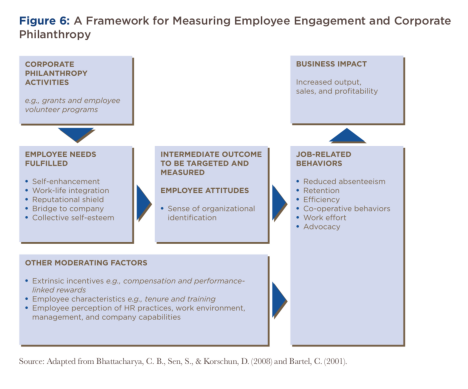

In [32]:
# Load and display a test image
image = Image.open("assets/lim-fig6.png")
plt.imshow(image)
plt.axis('off')

In [33]:
print(wrap(pipe("Describe what is presented in this image", image=image, max_new_tokens=512)))

The image is a diagram titled "Figure 6: A Framework for Measuring Employee
Engagement and Corporate Philanthropy." It is divided into several sections,
each with a specific focus. The top left section is labeled "CORPORATE
PHILANTHROPY ACTIVITIES" and includes examples such as grants and employee
volunteer programs. The top right section is labeled "BUSINESS IMPACT" and lists
outcomes like increased output, sales, and profitability. Below these sections,
there are three main columns. The first column on the left is labeled "EMPLOYEE
NEEDS FULFILLED" and includes points such as self-enhancement, work-life
integration, reputational shield, bridge to company, and collective self-esteem.
The middle column is labeled "INTERMEDIATE OUTCOME TO BE TARGETED AND MEASURED"
and includes "EMPLOYEE ATTITUDES" and "Sense of organizational identification."
The third column on the right is labeled "JOB-RELATED BEHAVIORS" and lists
outcomes like reduced absenteeism, retention, efficiency, co-operative


Probing the model's image reasoning capabilities:

(np.float64(-0.5), np.float64(999.5), np.float64(562.5), np.float64(-0.5))

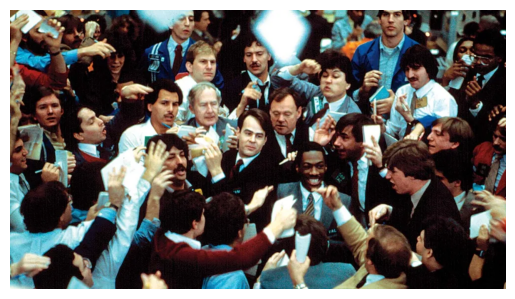

In [34]:
# Load and display a test image
image = Image.open("assets/MSDTRPL_EC013-H-2020-1602198302.webp")
plt.imshow(image)
plt.axis('off')

In [35]:
print(wrap(pipe("What is shown in this image?", image=image, max_new_tokens=512)))

The image depicts a large crowd of people, many of whom are holding up their
hands. The crowd appears to be in a state of excitement or celebration, with
some individuals raising their hands in the air. The people are dressed in a
variety of clothing, including suits and casual attire. The background is filled
with more people, suggesting that this is a public event or gathering.


In [36]:
print(wrap(pipe("Identify the movie that this scene is taken from, and explain your reasoning",
                image=image, max_new_tokens=128)))

This scene is from the movie 'Forrest Gump.' The reasoning behind this
identification includes the distinctive style of the crowd, the casual yet
significant attire of the individuals, and the overall chaotic yet focused
atmosphere typical of a pivotal moment in the film. The scene captures a moment
of intense public reaction, which is a recurring theme in the movie.


In [37]:
print(wrap(pipe("Please give your best estimate of the number of people in this image",
                image=image, max_new_tokens=32)))

There are approximately 30 people visible in the image.


In [38]:
print(wrap(pipe("Briefly recount a specific instance of corporate philanthropy in the plot of the movie Trading Places?",
          max_new_tokens=512)))

In the movie "Trading Places," a notable instance of corporate philanthropy
occurs when Louis Winthorpe III, played by Eddie Murphy, and Billy Ray
Valentine, played by Dan Akroyd, are swapped due to a bet. Louis, who is a
successful commodities trader, is given a chance to live a life of luxury and
privilege, while Billy, a struggling street trader, is given Louis' life.

During this period, Louis, who is now living a life of luxury, decides to use
his newfound wealth to help those in need. He donates a significant amount of
money to a local homeless shelter, which is a clear act of corporate
philanthropy. This act not only helps the shelter but also serves as a turning
point in Louis' character development, as he begins to understand the value of
giving back to the community.

This instance of corporate philanthropy in the movie highlights the importance
of using wealth and resources to help those in need, and it also serves as a
reminder that even those who are successful can make a 

### Audio

Finally, perform automatic speech recognition (ASR) and speech translation on an audio input.

Rigorous open benchmark datasets for evaluation are also available, e.g.

https://github.com/huggingface/open_asr_leaderboard

In [39]:
# Perform speech-to-text on an audio file
url = "assets/pork-bellies!.mp3"
audio, samplerate = soundfile.read(url)
response = pipe("Transcribe the audio to text", 
                audio=[(audio, samplerate)], max_new_tokens=512)
print(wrap(response))

Pork bellies! I have a hunch something very exciting is going to happen in the
pork belly market this morning.


In [ ]:
from playsound import playsound
playsound(url)   # play the original sound file


__References:__

Patrick Lewis, Ethan Perez, Aleksandra Piktus, Fabio Petroni, Vladimir Karpukhin, Naman Goyal†, Heinrich Küttler, Mike Lewis†, Wen-tau Yih, Tim Rocktäschel, Sebastian Riedel, Douwe Kiela, 2021, Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks

Danqi Chen, Adam Fisch, Jason Weston, Antoine Bordes. (2017), "Reading Wikipedia to Answer Open-Domain Questions."

Ori Ram, Yoav Levine, Itay Dalmedigos, Dor Muhlgay, Amnon Shashua, Kevin Leyton-Brown, Yoav Shoham (2023), "In-Context Retrieval-Augmented Language Models."

Kyle Mahowald and Anna A. Ivanova and Idan A. Blank and Nancy Kanwisher and Joshua B. Tenenbaum and Evelina Fedorenko, 2024, Dissociating language and thought in large language models, https://arxiv.org/abs/2301.06627

Hicks, Michael Townsen, Humphries, James and Slater, Joe, 2024, "ChatGPT is bullshit", Ethics and Information Technology
Volume 26, Issue 2, https://doi.org/10.1007/s10676-024-09775-5

Parth Sarthi and Salman Abdullah and Aditi Tuli and Shubh Khanna and Anna Goldie and Christopher D. Manning, 2024, RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval, https://arxiv.org/abs/2401.18059

https://github.com/NirDiamant/RAG_Techniques

Lim, Terence, 2010, Measuring the value of corporate philanthropy: Social impact, business benefits, and investor returns. published by CECP.

